In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from load_utils import *

### Load Data

In [2]:
# Load scored diffs and moderation event data
d = load_diffs()
df_block_events, df_blocked_user_text = load_block_events_and_users()
df_warn_events, df_warned_user_text = load_warn_events_and_users()

In [22]:
moderated_users = [('warned', df_warned_user_text),
                   ('blocked', df_blocked_user_text),
                   ('either', pd.concat([df_warned_user_text, df_blocked_user_text]))
                  ]
moderation_events = [('warned', df_warn_events),
                     ('blocked', df_block_events),
                     ('either', pd.concat([df_warn_events, df_block_events]))
                    ]

In [36]:
moderation_events_2015 = [('warned', df_warn_events.query('year == 2015')),
                          ('blocked', df_block_events.query('year == 2015')),
                          ('either', pd.concat([df_warn_events.query('year == 2015'), df_block_events.query('year == 2015')]))
                         ]

moderated_users_2015 = [('warn', df_warn_events.query('year == 2015')[['user_text']].assign(blocked = 1)),
                        ('block', df_block_events.query('year == 2015')[['user_text']].assign(blocked = 1)),
                        ('either', pd.concat([df_warn_events.query('year == 2015')[['user_text']].assign(blocked = 1), df_block_events.query('year == 2015')[['user_text']].assign(blocked = 1)]))
                  ]

### Q: Are new attacks from blocked users more likely to lead to a block? P(blocked | attacked and blocked k times already)

The methodology for this is a bit involved. 

- events[i]: the set of ith block events per user
- blocked_users[i] = set of users blocked i times, e.g. set of users in events[i]
- attacks[i]: the set of attacks made by users after their ith block, excluding comments made after their (i+1)th block, if it happened.
- attackers[i]: set of users in attacks[i]
- P(blocked | attacked and blocked k times already): $$ \frac{|blocked[k+1] \cap attackers[k]|}{|attackers[k]|}$$

In [6]:
K = 6
sample = 'blocked'
er_t = 0.425

In [7]:
events = {}

# null events set
e = d[sample][['user_text']].drop_duplicates()
e['timestamp'] = pd.to_datetime('1900')
events[0] = e

# rank block events
ranked_events = df_block_events.copy()
ranks = df_block_events\
.groupby('user_text')['timestamp']\
.rank()
ranked_events['rank'] = ranks

for k in range(1,K):
    e = ranked_events.query("rank==%d" % k)[['user_text', 'timestamp']]
    events[k] = e

In [8]:
attacks = {}
for k in range(0, K-1):
    c = d[sample].merge(events[k], how = 'inner', on='user_text')
    c = c.query('timestamp < rev_timestamp')
    del c['timestamp']
    c = c.merge(events[k+1], how = 'left', on = 'user_text')
    c['timestamp'] = c['timestamp'].fillna(pd.to_datetime('2100'))
    c = c.query('rev_timestamp < timestamp')
    c = c.query('pred_recipient_score_uncalibrated > %f' % er_t)
    attacks[k] = c

In [9]:
blocked_users = {i:set(events[i]['user_text']) for i in events.keys()}
attackers = {i:set(attacks[i]['user_text']) for i in attacks.keys()}

In [10]:
dfs_sns = []

for k in range(1, K-1):
    u_a = attackers[k]
    u_b = blocked_users[k+1]
    u_ab = u_a.intersection(u_b)
    n_a = len(u_a)
    n_ab = len(u_ab)
    print('k:',k,  n_ab/n_a)
    
    dfs_sns.append(pd.DataFrame({'blocked': [1]*n_ab, 'k': [k]*n_ab}))
    dfs_sns.append(pd.DataFrame({'blocked': [0]*(n_a- n_ab), 'k': [k]*(n_a- n_ab)}))

k: 1 0.3191358024691358
k: 2 0.4208955223880597
k: 3 0.5217391304347826
k: 4 0.6470588235294118


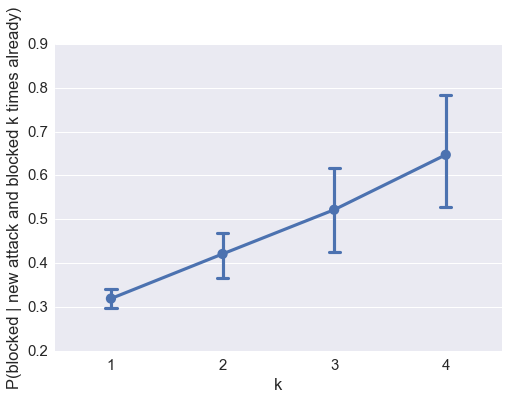

In [157]:
sns.set(font_scale=1.5)
sns.pointplot(x = 'k', y = 'blocked', data = pd.concat(dfs_sns), capsize=.1)
plt.xlabel('k')
plt.ylabel('P(blocked | new attack and blocked k times already)')
plt.savefig('../../paper/figs/p_of_blocked_given_new_attack_and_blocked_already.png')

The probability of being blocked after making a personal attack and increases as a function of how many times the user has been blocked before. This could indicate heightened scrutiny by administrators. The pattern could also occur if users who continue to attack after being blocked make more frequent or more toxic attacks and are hence more likely to be discovered. 

TODO
- check if users make more or more toxic attacks after being blocked
- it could even be that they get blocked for smaller offenses

### Q: What fraction of attacking comments were followed by a warn or block event?
Within one week

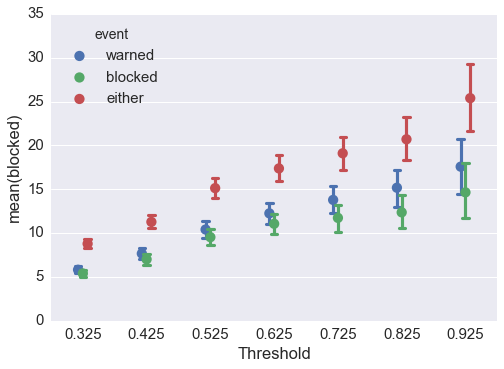

In [24]:
dfs = []
ts = np.arange(0.325, 0.96, 0.1)

def get_delta(x):
    if x['timestamp'] is not None and x['rev_timestamp'] is not None:
        return x['timestamp'] - x['rev_timestamp']
    else:
        return pd.Timedelta('0 seconds') 
    
for t in ts:
    for (event_type, events) in moderation_events:
        dfs.append(
                    d['2015'].query('pred_recipient_score_uncalibrated >= %f' % t)\
                            .loc[:, ['user_text', 'rev_id', 'rev_timestamp']]\
                            .merge(events, how = 'left', on = 'user_text')\
                            .assign(delta = lambda x: get_delta(x))\
                            .assign(blocked= lambda x: 100 * ((x['delta'] <  pd.Timedelta('7 days')) & (x['delta'] >  pd.Timedelta('0 seconds'))))\
                            .drop_duplicates(subset = ['rev_id'])\
                            .assign(threshold = t, event=event_type)
                    )
ax = sns.pointplot(x='threshold', y='blocked', hue='event', data = pd.concat(dfs), dodge=0.15, capsize=.1, linestyles=[" ", "", " "])
plt.xlabel('Threshold')
#ax.set_ylabels('% of attacks followed bymoderation')

In [25]:
pd.concat(dfs).groupby(['threshold','event'])['blocked'].mean()

threshold  event  
0.325      blocked     5.399696
           either      8.788237
           warned      5.822207
0.425      blocked     7.013442
           either     11.279953
           warned      7.670953
0.525      blocked     9.538077
           either     15.131086
           warned     10.411985
0.625      blocked    11.065726
           either     17.378388
           warned     12.253992
0.725      blocked    11.738649
           either     19.102990
           warned     13.787375
0.825      blocked    12.368421
           either     20.701754
           warned     15.175439
0.925      blocked    14.648438
           either     25.390625
           warned     17.578125
Name: blocked, dtype: float64

Most attacking comments do not lead to the user being warned/blocked within the next 7 days.

### Q: How does the probablity of a user being blocked change with the number of attacking comments?

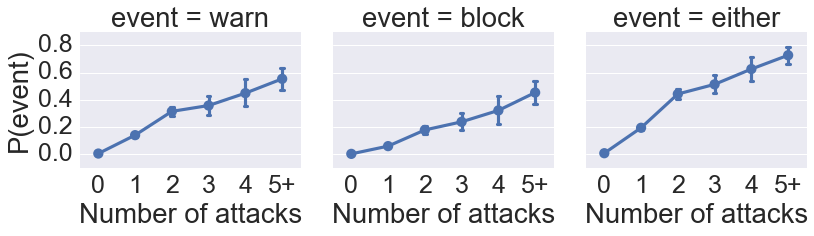

In [37]:
def remap(x):
    if x < 5:
        return str(int(x))
    else:
        return '5+'
    
sns.set(font_scale=2.5)        
dfs = []

for event_type, users in moderated_users_2015:
    dfs.append(\

               d['2015'].assign(attack = lambda x: x.pred_recipient_score_uncalibrated >=  0.425)\
                .groupby('user_text', as_index = False)['attack'].sum()\
                .rename(columns={'attack':'num_attacks'})\
                .merge(users, how = 'left', on = 'user_text')\
                .assign(
                    blocked = lambda x: x.blocked.fillna(0,),
                    num_attacks = lambda x: x.num_attacks.apply(remap),
                    event = event_type)
               )
df = pd.concat(dfs)

g = sns.factorplot(x = 'num_attacks',
                   y = 'blocked',
                   col = 'event', data = df, order = ('0', '1', '2', '3','4', '5+'), capsize=.1)
g.set_ylabels('P(event)')
g.set_xlabels('Number of attacks')
plt.savefig('../../paper/figs/fraction_blocked_given_num_attacks.png')


The more attacks a user makes, the more likely it is that they will have been blocked at least once.

### Probablity of block in 7 days after attack as a function of # of previous blocks

In [149]:
attacks = d['blocked'].query("pred_recipient_score_uncalibrated >=  0.425").query("not author_anon").query("not own_page")

In [154]:
results = []
for i , r in attacks.iterrows():
    ts = r['rev_timestamp']
    user = r['user_text']
    user_blocks = df_block_events[df_block_events['user_text'] == user]
    prior_blocks = user_blocks[user_blocks['timestamp'] < ts ]
    max_ts = prior_blocks['timestamp'].max()
    #if ts < (max_ts + pd.Timedelta('60 days')):
    #    continue
    post_blocks = user_blocks[user_blocks['timestamp'] > ts]
    n_blocks_prior =  prior_blocks.shape[0]
    blocked_again = post_blocks.shape[0] > 0
    
    for days in [7, 14, 30, 60, 90, 180]:
        within_x = post_blocks[post_blocks['timestamp'] < (ts + pd.Timedelta('%d days' % days)) ].shape[0] > 0
        results.append({'n_blocks_prior': n_blocks_prior,
                        'blocked_again': within_x,
                        'within_x': days
                       })


In [155]:
df = pd.DataFrame(results)

def remap(x):
    if x < 5:
        return str(int(x))
    else:
        return '5+'
    
df['n_blocks_prior'] = df['n_blocks_prior'].apply(remap)

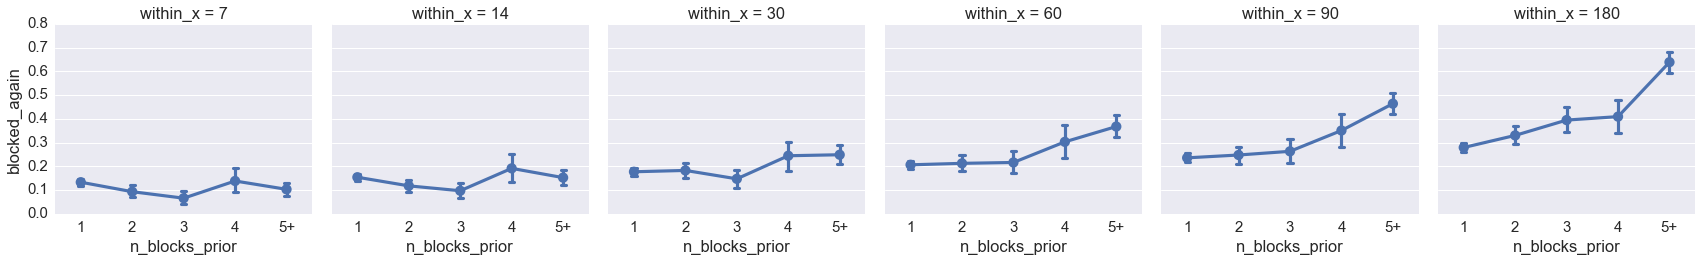

In [156]:
sns.set(font_scale=1.5)        

g = sns.factorplot(x = 'n_blocks_prior',
                   y = 'blocked_again',
                   col = 'within_x',
                   data = df,
                   capsize=.1,
                   order = [ '1', '2', '3', '4', '5+']
                  )
#g.set_ylabels('P(attack followed by block | # prior blocks)')
#g.set_xlabels('Number of prior blocks')
plt.savefig('../../paper/figs/8.png')